In [1]:
import scanpy as sc
import stream2 as st2
import numpy as np
import pandas as pd
import pyorthomap
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import os
import scipy

# Convert ArchR mtx to anndata

In [2]:
X = scipy.io.mmread('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/matrix.mtx.gz')
adata_peak = sc.AnnData(X.tocsr(),dtype=X.dtype)
adata_peak.var=pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/annotation.csv',index_col=0)
adata_peak.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/Archr_peaks.h5ad')
scipy.sparse.save_npz('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/Archr_peaks.npz',adata_peak.X.T)

# Motif matrix

In [ ]:
%%R
suppressMessages(library(chromVAR))
suppressMessages(library(Matrix))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(BiocParallel))
suppressMessages(library(data.table))

set.seed(2022)

input='/shared/projects/idim'
species="Homo sapiens"
genome='hg38'
feature='motif'
n_jobs=4

print(paste0('Using',n_jobs,'cores...',sep = " "))
register(MulticoreParam(n_jobs))

### Read in data files
print(paste0('Read in regions: ', input, '/region_file.bed...'))
peaks <- makeGRangesFromDataFrame(data.frame(fread(paste0(input,'/region_file.bed'),col.names=c('seqnames','start','end'))))

print(paste0('Read in samples from ', input, '/sample_file.tsv'))
samples <- data.frame(fread(paste0(input,'/sample_file.tsv'),header=FALSE))

print(paste0('Read in counts from ', input, '/count_file.mtx.gz'))
counts <- readMM(paste0(input,'/count_file.mtx.gz'))

if(dim(counts)[1] == dim(samples)[1]){
    print('Transpose counts')
    counts <- t(counts)
}
colnames(counts) <- samples[,1]

### Main Calculation
# Make RangedSummarizedExperiment
SE <- SummarizedExperiment(
  rowRanges = peaks,
  colData = samples,
  assays = list(counts = counts)
)

# Add GC bias
print('Add GC bias ...')
SE <- addGCBias(SE, genome = genome)

print('Filter peaks ...')
SE <- filterPeaks(SE, non_overlapping = TRUE)

print('Get background peaks ...')
bg <- getBackgroundPeaks(SE)

if(feature == 'kmer'){
  # compute kmer deviations
  print('k-mer counting...')   
  kmer_ix <- matchKmers(k, SE, genome = genome)
  print('Computing k-mer deviations...') 
  dev <- computeDeviations(object = SE, annotations = kmer_ix,background_peaks = bg)
}
if(feature == 'motif'){
  # compute motif deviations
  suppressMessages(library('JASPAR2022')) 
  suppressMessages(library('motifmatchr'))
  print('motif matching...')
  
  getJasparMotifs <- function(species = "Homo sapiens", 
                                collection = "CORE", ...) {
    opts <- list()
    opts["species"] <- species
    opts["collection"] <- collection
    opts <- c(opts, list(...))
    out <- TFBSTools::getMatrixSet(JASPAR2022::JASPAR2022, opts)
    if (!isTRUE(all.equal(TFBSTools::name(out), names(out)))) 
      names(out) <- paste(names(out), TFBSTools::name(out), sep = "_")
    return(out)
  }   
    
  motifs_h <- getJasparMotifs(species = 'Homo sapiens')
  motifs_m <- getJasparMotifs(species = 'Mus musculus')
  motifs <- append(motifs_h, motifs_m)
  motif_ix <- matchMotifs(motifs, SE, genome = genome)
  print('Computing motif deviations...')
  dev <- computeDeviations(object = SE, annotations = motif_ix, background_peaks = bg)
}

devTable <- assays(dev)[["deviations"]]
zTable <- assays(dev)[["z"]]

print('Saving zscores...')
write.table(devTable, file = gzfile(file.path(input,"deviations_hg38.tsv.gz")), sep = "\t", quote = FALSE, row.names = TRUE, col.names=NA)
write.table(zTable, file = gzfile(file.path(input,"zTable_hg38.tsv.gz")), sep = "\t", quote = FALSE, row.names = TRUE, col.names=NA)

species_list <- c()
for (i in 1:length(motifs)){
    species_list <- c(species_list, motifs[[i]]@tags$species[[1]])
}
species_df <- data.frame(names(motifs),species_list)
write.csv(species_df,file.path(input,'species_df.csv'))

In [ ]:
### ATAC to motif using stream2
#!conda create -n stream2_chromVar R -y
#!conda activate stream2_chromVar
#!conda install -c conda-forge r-biocmanager -y
#!conda install -c bioconda r-anndata bioconductor-chromvar bioconductor-bsgenome.mmusculus.ucsc.mm10 bioconductor-jaspar2016 bioconductor-jaspar2020 bioconductor-motifmatchr -y
#!conda install BiocManager::install("rhdf5")
#conda install -c conda-forge r-seuratdisk -y
#!bash -i /mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/preprocessing/check_env.sh stream2_chromVar . MusMusculus mm10 motif 4
#adata_motif = st2.pp.atac_chromVar(adata_CP, scale=True, species='MusMusculus', genome='mm10', 
#                            feature='motif', n_jobs=4, env = 'stream2_chromVar', 
#                                  outdir='.')

In [ ]:
### Mouse --> human gene names conversion in R
#library(tidyr)
#library(biomaRt)
#
#convertGeneList <- function(x, from='human'){
#
#hum_mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")
#hum_atr <- 'hgnc_symbol'
#mus_mart <- useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")
#mus_atr <- 'mgi_symbol'
#
#if (from == 'human') {
#    genesV2 <- getLDS(attributes = hum_atr, filters = hum_atr, values = x , mart = hum_mart,
#                      attributesL = mus_atr, martL = mus_mart, uniqueRows=T) 
#} else if (from == 'mouse') {
#    genesV2 <- getLDS(attributes = mus_atr, filters = mus_atr, values = x , mart = mus_mart,
#                      attributesL = hum_atr, martL = hum_mart, uniqueRows=T)
#} else {
#    print('Supported inputs for arg from is "human" or "mouse"')
#}
#     
#genesV2_sort <- genesV2[match(x, genesV2[, 1]), ] 
##outx <- unique(genesV2_sort[, 2])
# 
#return(genesV2_sort)
#}
#
#musAnno <- data.frame(lable=names(motifs_m), source = 'mouse', ID_names=names(motifs_m))
#musAnno <- separate(data = musAnno, col = ID_names, into = c("ID", "names"), sep = "_")
#musAnno <- separate(data = musAnno, col = names, into = c("names_1", "names_2"), sep = "::")
#
#
#### convert mouse names to human names
#musAnno_norm <- musAnno[is.na(musAnno['names_2']), ]
#mus2hum <- convertGeneList(musAnno_norm$names_1, from='mouse')
#musAnno_norm['names_1_human'] <- mus2hum[,2]
#musAnno_norm['names_1_mouse'] <- musAnno_norm['names_1']
#
#musAnno_joint_raw <- musAnno[!is.na(musAnno['names_2']), ]
#
## split joint TFs
#n <- range(dim(musAnno_joint_raw)[1])
#musAnno_joint <- musAnno_joint_raw
#for(i in 1:range(n)){
#  musAnno_joint <- rbind(musAnno_joint, data.frame(lable=musAnno_joint_raw[i,'lable'], source='mouse', ID=musAnno_joint_raw[i,'ID'], names_1=musAnno_joint_raw[i,'names_2'], names_2=NA))
#}
#mus2hum <- convertGeneList(musAnno_joint$names_1, from='mouse')
#musAnno_joint['names_1_human'] <- mus2hum[,2]
#musAnno_joint['names_1_mouse'] <- musAnno_joint['names_1']
#
#musAnno <- rbind(musAnno_norm, musAnno_joint)
#
#### convert human names
#humAnno <- data.frame(lable=names(motifs_h), source = 'human', ID_names=names(motifs_h))
#humAnno <- separate(data = humAnno, col = ID_names, into = c("ID", "names"), sep = "_")
#humAnno <- separate(data = humAnno, col = names, into = c("names_1", "names_2"), sep = "::")
#
#humAnno_norm = humAnno[is.na(humAnno['names_2']), ]
#hum2mus <- convertGeneList(humAnno_norm$names_1, from='human')
#humAnno_norm['names_1_human'] <- humAnno_norm['names_1']
#humAnno_norm['names_1_mouse'] <- hum2mus[,2]
#
#humAnno_joint_raw <- humAnno[!is.na(humAnno['names_2']), ]
#
## split joint TFs
#n <- dim(humAnno_joint_raw)[1]
#humAnno_joint <- humAnno_joint_raw
#for(i in 1:n){
#  humAnno_joint <- rbind(humAnno_joint, data.frame(lable=humAnno_joint_raw[i,'lable'], source='human', ID=humAnno_joint_raw[i,'ID'], names_1=humAnno_joint_raw[i,'names_2'], names_2=NA))
#}
#
#hum2mus <- convertGeneList(humAnno_joint$names_1, from='human')
#humAnno_joint['names_1_human'] <- humAnno_joint['names_1']
#humAnno_joint['names_1_mouse'] <- hum2mus[,2]
#
#humAnno <- rbind(humAnno_norm, humAnno_joint)
#
#allAnno <- rbind(humAnno, musAnno)
#allAnno$names_1 <- NULL
#allAnno$names_2 <- NULL
#colnames(allAnno)=c("ID","source","JASPARID","humNames","musNames")

# Read

In [12]:
### Read and clean up
df = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/deviations.tsv.gz', index_col=0, sep='\t').T
dfz = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/zTable.tsv.gz', index_col=0, sep='\t').T
df_species = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/species_df.csv', index_col=0)
df_species[['ID','symbol']] = df_species['names.motifs.'].str.split('_',expand=True)
df_species[['symbol1','symbol2']]=df_species['symbol'].str.split('::',expand=True)

# find duplicate columns
n,c=np.unique(df.columns.str.upper(),return_counts=1)
print('duplicated columns:',n[c>1])

# remove duplicate column
assert (df_species['names.motifs.']==df.columns).all() and (dfz.columns==df.columns).all()
assert all(df[n[c>1]].iloc[:,0]==df[n[c>1]].iloc[:,1])
keep_ix = np.setdiff1d(np.arange(df.shape[1]),np.where(df.columns==n[c>1][0])[0][-1])

df = df.iloc[:,keep_ix]
dfz = dfz.iloc[:,keep_ix]
df_species = df_species.iloc[keep_ix]

# impute the few missing values
df[:] = KNNImputer().fit_transform(df)
dfz[:] = KNNImputer().fit_transform(dfz)

### mouse --> human

#pip install git+https://github.com/vitkl/orthologsBioMART.git

ix_mm = df_species['species_list']=='Mus musculus'
symbols_u = np.unique(np.array(df_species.loc[ix_mm,['symbol1','symbol2']]).astype(str).flatten())
symbols_u = symbols_u[symbols_u!='None']
df_mmhs = pyorthomap.findOrthologsMmHs(from_filters = 'external_gene_name',from_values=symbols_u).map()

mm2hs = {}
missing = []
for s in symbols_u:
    if s in df_mmhs['external_gene_name'].values:
        mm2hs[s]=df_mmhs.loc[df_mmhs['external_gene_name']==s,'hgnc_symbol'].iloc[0]
    else:
        missing.append(s)
        mm2hs[s]=s.upper()
        
# edge cases
n,c=np.unique(df_mmhs['external_gene_name'],return_counts=1)
print('duplicates:\n',df_mmhs[df_mmhs['external_gene_name'].isin(np.hstack((n[c>1])))])
print('\nmissing (upper cased):\n',missing)
print('\nNaN:\n',pd.Series(mm2hs)[pd.Series(mm2hs).isna()])

# edge cases handling
mm2hs['Pou5f1']='POU5F1'
mm2hs['Mscx3']='Mscx3'
mm2hs['Rhox11']='Rhox11'
mm2hs[None]=None

for c in ['symbol1','symbol2']:
    df_species[f'{c}_hs'] = df_species[f'{c}']
    df_species.loc[ix_mm,f'{c}_hs'] = [mm2hs[s] for s in df_species.loc[ix_mm,f'{c}_hs']]
    
df_species['symbol_hs']=df_species['symbol1_hs'].astype(str)
for i in df_species.index:
    if type(df_species['symbol2_hs'][i])==str:
        df_species['symbol_hs'][i]= df_species['symbol_hs'][i]+'::'+df_species['symbol2_hs'][i]
df_species['names.motifs.hs']=df_species['ID']+'_'+df_species['symbol_hs']

### Create anndata

# just to fetch obs_names
adata_gs=sc.read('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_imputed_log_gene_score.h5ad')

adata_motif=sc.AnnData(df)
adata_motif.var = df_species.set_index("names.motifs.hs")
adata_motif.obs = adata_gs.obs
adata_motif.obsm = adata_gs.obsm
adata_motif.obs_names = adata_gs.obs_names
adata_motif.uns = adata_gs.uns
adata_motif.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/chromVAR_deviations.h5ad')
adata_motif.X=dfz
adata_motif.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/chromVAR_zscores.h5ad')

duplicated columns: ['MA0259.1_ARNT::HIF1A']


  0%|          | 0/1 [00:00<?, ?it/s]

duplicates:
     hgnc_symbol human_ensembl_gene_id mouse_ensembl_gene_id external_gene_name
121      POU5F1       ENSG00000204531    ENSMUSG00000024406             Pou5f1
122     POU5F1B       ENSG00000212993    ENSMUSG00000024406             Pou5f1

missing (upper cased):
 ['Bcl11B', 'Dux', 'Gfi1B', 'Hnf1A', 'NR5A1', 'Nr1H2', 'Nr1H4', 'Nr2F6', 'Nr5A2', 'Ptf1A']

NaN:
 Msx3      NaN
Rhox11    NaN
dtype: object


/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


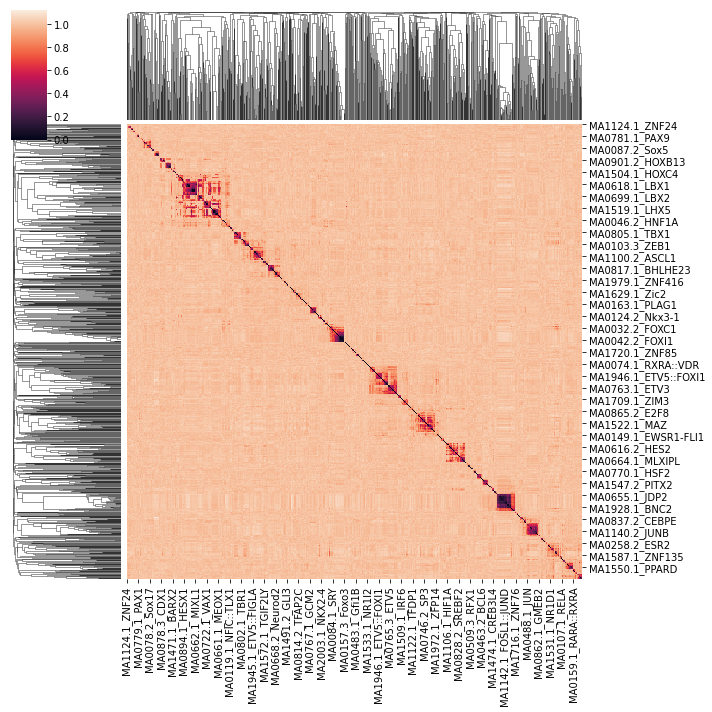

In [503]:
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

#dups = df.T.duplicated()
D = 1-df.corr()#.loc[:,dups].corr()
linkage = hc.linkage(sp.distance.squareform(D), method='average')
sns.clustermap(D, row_linkage=linkage, col_linkage=linkage)

# Read archr

In [3]:
adata_motif = sc.read('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_motifs_JASPAR2022.h5ad')

# find duplicate columns
n,c=np.unique(adata_motif.var_names.str.upper(),return_counts=1)
assert len(n[c>1])==0
# find nan values
assert np.isnan(adata_motif.X.toarray()).sum()==0

df_species = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/species_df_JASPAR2022.csv',index_col=0)
df_species[['ID','symbol']] = df_species['names.motifs_pw_no_dups.'].str.split('_',expand=True)
df_species[['symbol1','symbol2']]=df_species['symbol'].str.split('::',expand=True)

### mouse --> human

#pip install git+https://github.com/vitkl/orthologsBioMART.git

ix_mm = df_species['species_list']=='Mus musculus'
symbols_u = np.unique(np.array(df_species.loc[ix_mm,['symbol1','symbol2']]).astype(str).flatten())
symbols_u = symbols_u[symbols_u!='None']
df_mmhs = pyorthomap.findOrthologsMmHs(from_filters = 'external_gene_name',from_values=symbols_u).map()

mm2hs = {}
missing = []
for s in symbols_u:
    if s in df_mmhs['external_gene_name'].values:
        mm2hs[s]=df_mmhs.loc[df_mmhs['external_gene_name']==s,'hgnc_symbol'].iloc[0]
    else:
        missing.append(s)
        mm2hs[s]=s.upper()
        
# edge cases
n,c=np.unique(df_mmhs['external_gene_name'],return_counts=1)
print('duplicates:\n',df_mmhs[df_mmhs['external_gene_name'].isin(np.hstack((n[c>1])))])
print('\nmissing (upper cased):\n',missing)
print('\nNaN:\n',pd.Series(mm2hs)[pd.Series(mm2hs).isna()])

# edge cases handling
mm2hs['Pou5f1']='POU5F1'
mm2hs['Mscx3']='Mscx3'
mm2hs['Rhox11']='Rhox11'
mm2hs[None]=None

for c in ['symbol1','symbol2']:
    df_species[f'{c}_hs'] = df_species[f'{c}']
    df_species.loc[ix_mm,f'{c}_hs'] = [mm2hs[s] for s in df_species.loc[ix_mm,f'{c}_hs']]
    
df_species['symbol_hs']=df_species['symbol1_hs'].astype(str)
for i in df_species.index:
    if type(df_species['symbol2_hs'][i])==str:
        df_species['symbol_hs'][i]= df_species['symbol_hs'][i]+'::'+df_species['symbol2_hs'][i]
df_species['names.motifs.hs']=df_species['ID']+'_'+df_species['symbol_hs']

### Organize anndata

# just to fetch obs_names
adata_gs=sc.read('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_imputed_log_gene_score.h5ad')
adata_motif.var = df_species.set_index("names.motifs_pw_no_dups.")
adata_motif.obs_names = adata_motif.obs_names.str.replace('#','-')
adata_motif.obs['label']=adata_gs.obs['label']
adata_motif=adata_motif[adata_gs.obs_names]
adata_motif.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_motifs_JASPAR2022.h5ad')

  0%|          | 0/1 [00:00<?, ?it/s]

duplicates:
     hgnc_symbol human_ensembl_gene_id mouse_ensembl_gene_id external_gene_name
121      POU5F1       ENSG00000204531    ENSMUSG00000024406             Pou5f1
122     POU5F1B       ENSG00000212993    ENSMUSG00000024406             Pou5f1

missing (upper cased):
 ['Bcl11B', 'Dux', 'Gfi1B', 'Hnf1A', 'NR5A1', 'Nr1H2', 'Nr1H4', 'Nr2F6', 'Nr5A2', 'Ptf1A']

NaN:
 Msx3      NaN
Rhox11    NaN
dtype: object


In [12]:
### Read and clean up
df = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr', index_col=0, sep='\t').T
dfz = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_raw_motif_z_score.csv', index_col=0, sep='\t').T
df_species = pd.read_csv('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peaks/species_df.csv', index_col=0)
df_species[['ID','symbol']] = df_species['names.motifs.'].str.split('_',expand=True)
df_species[['symbol1','symbol2']]=df_species['symbol'].str.split('::',expand=True)

# find duplicate columns
n,c=np.unique(df.columns.str.upper(),return_counts=1)
print('duplicated columns:',n[c>1])

# remove duplicate column
assert (df_species['names.motifs.']==df.columns).all() and (dfz.columns==df.columns).all()
assert all(df[n[c>1]].iloc[:,0]==df[n[c>1]].iloc[:,1])
keep_ix = np.setdiff1d(np.arange(df.shape[1]),np.where(df.columns==n[c>1][0])[0][-1])

df = df.iloc[:,keep_ix]
dfz = dfz.iloc[:,keep_ix]
df_species = df_species.iloc[keep_ix]

# impute the few missing values
df[:] = KNNImputer().fit_transform(df)
dfz[:] = KNNImputer().fit_transform(dfz)

### mouse --> human

#pip install git+https://github.com/vitkl/orthologsBioMART.git

ix_mm = df_species['species_list']=='Mus musculus'
symbols_u = np.unique(np.array(df_species.loc[ix_mm,['symbol1','symbol2']]).astype(str).flatten())
symbols_u = symbols_u[symbols_u!='None']
df_mmhs = pyorthomap.findOrthologsMmHs(from_filters = 'external_gene_name',from_values=symbols_u).map()

mm2hs = {}
missing = []
for s in symbols_u:
    if s in df_mmhs['external_gene_name'].values:
        mm2hs[s]=df_mmhs.loc[df_mmhs['external_gene_name']==s,'hgnc_symbol'].iloc[0]
    else:
        missing.append(s)
        mm2hs[s]=s.upper()
        
# edge cases
n,c=np.unique(df_mmhs['external_gene_name'],return_counts=1)
print('duplicates:\n',df_mmhs[df_mmhs['external_gene_name'].isin(np.hstack((n[c>1])))])
print('\nmissing (upper cased):\n',missing)
print('\nNaN:\n',pd.Series(mm2hs)[pd.Series(mm2hs).isna()])

# edge cases handling
mm2hs['Pou5f1']='POU5F1'
mm2hs['Mscx3']='Mscx3'
mm2hs['Rhox11']='Rhox11'
mm2hs[None]=None

for c in ['symbol1','symbol2']:
    df_species[f'{c}_hs'] = df_species[f'{c}']
    df_species.loc[ix_mm,f'{c}_hs'] = [mm2hs[s] for s in df_species.loc[ix_mm,f'{c}_hs']]
    
df_species['symbol_hs']=df_species['symbol1_hs'].astype(str)
for i in df_species.index:
    if type(df_species['symbol2_hs'][i])==str:
        df_species['symbol_hs'][i]= df_species['symbol_hs'][i]+'::'+df_species['symbol2_hs'][i]
df_species['names.motifs.hs']=df_species['ID']+'_'+df_species['symbol_hs']

### Create anndata

# just to fetch obs_names
adata_gs=sc.read('../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_imputed_log_gene_score.h5ad')

adata_motif=sc.AnnData(df)
adata_motif.var = df_species.set_index("names.motifs.hs")
adata_motif.obs = adata_gs.obs
adata_motif.obsm = adata_gs.obsm
adata_motif.obs_names = adata_gs.obs_names
adata_motif.uns = adata_gs.uns
adata_motif.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/chromVAR_deviations.h5ad')
adata_motif.X=dfz
adata_motif.write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/chromVAR_zscores.h5ad')

duplicated columns: ['MA0259.1_ARNT::HIF1A']


  0%|          | 0/1 [00:00<?, ?it/s]

duplicates:
     hgnc_symbol human_ensembl_gene_id mouse_ensembl_gene_id external_gene_name
121      POU5F1       ENSG00000204531    ENSMUSG00000024406             Pou5f1
122     POU5F1B       ENSG00000212993    ENSMUSG00000024406             Pou5f1

missing (upper cased):
 ['Bcl11B', 'Dux', 'Gfi1B', 'Hnf1A', 'NR5A1', 'Nr1H2', 'Nr1H4', 'Nr2F6', 'Nr5A2', 'Ptf1A']

NaN:
 Msx3      NaN
Rhox11    NaN
dtype: object


/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
